In [ ]:
!pip install d2l==0.16.1

In [13]:
from d2l import torch as d2l
import torch
from torch import nn
from torch.nn import functional as F
import time

# Networks with Parallel Concatenations (GoogLeNet)


In [3]:


class Inception(nn.Module):
    # `c1`--`c4` are the number of output channels for each path
    def __init__(self, in_channels, c1, c2, c3, c4, **kwargs):
        super(Inception, self).__init__(**kwargs)
        # Path 1 is a single 1 x 1 convolutional layer
        self.p1_1 = nn.Conv2d(in_channels, c1, kernel_size=1)
        # Path 2 is a 1 x 1 convolutional layer followed by a 3 x 3
        # convolutional layer
        self.p2_1 = nn.Conv2d(in_channels, c2[0], kernel_size=1)
        self.p2_2 = nn.Conv2d(c2[0], c2[1], kernel_size=3, padding=1)
        # Path 3 is a 1 x 1 convolutional layer followed by a 5 x 5
        # convolutional layer
        self.p3_1 = nn.Conv2d(in_channels, c3[0], kernel_size=1)
        self.p3_2 = nn.Conv2d(c3[0], c3[1], kernel_size=5, padding=2)
        # Path 4 is a 3 x 3 maximum pooling layer followed by a 1 x 1
        # convolutional layer
        self.p4_1 = nn.MaxPool2d(kernel_size=3, stride=1, padding=1)
        self.p4_2 = nn.Conv2d(in_channels, c4, kernel_size=1)

    def forward(self, x):
        p1 = F.relu(self.p1_1(x))
        p2 = F.relu(self.p2_2(F.relu(self.p2_1(x))))
        p3 = F.relu(self.p3_2(F.relu(self.p3_1(x))))
        p4 = F.relu(self.p4_2(self.p4_1(x)))
        # Concatenate the outputs on the channel dimension
        return torch.cat((p1, p2, p3, p4), dim=1)



## GoogLeNet Model




In [4]:
b1 = nn.Sequential(nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3),
                   nn.ReLU(),
                   nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

The second module uses two convolutional layers:
first, a 64-channel $1\times 1$ convolutional layer,
then a $3\times 3$ convolutional layer that triples the number of channels. This corresponds to the second path in the Inception block.


In [5]:
b2 = nn.Sequential(nn.Conv2d(64, 64, kernel_size=1),
                   nn.ReLU(),
                   nn.Conv2d(64, 192, kernel_size=3, padding=1),
                   nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

The third module connects two complete Inception blocks in series.
The number of output channels of the first Inception block is
$64+128+32+32=256$,
and the number-of-output-channel ratio
among the four paths is $64:128:32:32=2:4:1:1$.
The second and third paths first reduce the number of input channels
to $96/192=1/2$ and $16/192=1/12$, respectively,
and then connect the second convolutional layer.
The number of output channels of the second Inception block
is increased to $128+192+96+64=480$, and the number-of-output-channel ratio
among the four paths is $128:192:96:64 = 4:6:3:2$.
The second and third paths first reduce the number of input channels
to $128/256=1/2$ and $32/256=1/8$, respectively.


In [6]:
b3 = nn.Sequential(Inception(192, 64, (96, 128), (16, 32), 32),
                   Inception(256, 128, (128, 192), (32, 96), 64),
                   nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

The fourth module is more complicated.
It connects five Inception blocks in series,
and they have $192+208+48+64=512$, $160+224+64+64=512$,
$128+256+64+64=512$, $112+288+64+64=528$,
and $256+320+128+128=832$ output channels, respectively.
The number of channels assigned to these paths is similar
to that in the third module:
the second path with the $3\times 3$ convolutional layer
outputs the largest number of channels,
followed by the first path with only the $1\times 1$ convolutional layer,
the third path with the $5\times 5$ convolutional layer,
and the fourth path with the $3\times 3$ maximum pooling layer.
The second and third paths will first reduce
the number of channels according to the ratio.
These ratios are slightly different in different Inception blocks.


In [7]:
b4 = nn.Sequential(Inception(480, 192, (96, 208), (16, 48), 64),
                   Inception(512, 160, (112, 224), (24, 64), 64),
                   Inception(512, 128, (128, 256), (24, 64), 64),
                   Inception(512, 112, (144, 288), (32, 64), 64),
                   Inception(528, 256, (160, 320), (32, 128), 128),
                   nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

The fifth module has two Inception blocks with $256+320+128+128=832$
and $384+384+128+128=1024$ output channels.
The number of channels assigned to each path
is the same as that in the third and fourth modules,
but differs in specific values.
It should be noted that the fifth block is followed by the output layer.
This block uses the global average pooling layer
to change the height and width of each channel to 1, just as in NiN.
Finally, we turn the output into a two-dimensional array
followed by a fully-connected layer
whose number of outputs is the number of label classes.


In [8]:
b5 = nn.Sequential(Inception(832, 256, (160, 320), (32, 128), 128),
                   Inception(832, 384, (192, 384), (48, 128), 128),
                   nn.AdaptiveAvgPool2d((1,1)),
                   nn.Flatten())

net = nn.Sequential(b1, b2, b3, b4, b5, nn.Linear(1024, 10))

The GoogLeNet model is computationally complex,
so it is not as easy to modify the number of channels as in VGG.
To have a reasonable training time on Fashion-MNIST,
we reduce the input height and width from 224 to 96.
This simplifies the computation.
The changes in the shape of the output
between the various modules are demonstrated below.


In [9]:
X = torch.rand(size=(1, 1, 96, 96))
for layer in net:
    X = layer(X)
    print(layer.__class__.__name__,'output shape:\t', X.shape)

Sequential output shape:	 torch.Size([1, 64, 24, 24])
Sequential output shape:	 torch.Size([1, 192, 12, 12])
Sequential output shape:	 torch.Size([1, 480, 6, 6])
Sequential output shape:	 torch.Size([1, 832, 3, 3])
Sequential output shape:	 torch.Size([1, 1024])
Linear output shape:	 torch.Size([1, 10])


## Training

As before, we train our model using the Fashion-MNIST dataset.
 We transform it to $96 \times 96$ pixel resolution
 before invoking the training procedure.


In [ ]:
lr, num_epochs, batch_size = 0.1, 10, 128
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size, resize=96)


loss 0.235, train acc 0.911, test acc 0.898
1298.7 examples/sec on cuda:0
511.80017709732056


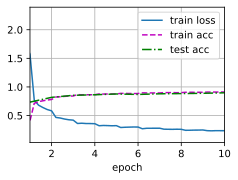

In [15]:
start = time.time()
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr)
end = time.time()
print(end - start)